In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, Model

import glob
import cv2
import re
import os
import matplotlib.pyplot as plt

2023-11-21 11:19:22.630772: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-21 11:19:22.661205: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 11:19:22.661240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 11:19:22.661261: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 11:19:22.666560: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-21 11:19:22.666971: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
def load_and_preprocess_image(image_path, mask_path):
    # Load and preprocess the image
    image = tf.keras.preprocessing.image.load_img(image_path)
    image = tf.keras.preprocessing.image.img_to_array(image)

    # Load and preprocess the mask
    mask = tf.keras.preprocessing.image.load_img(mask_path)
    mask = tf.keras.preprocessing.image.img_to_array(mask)

    image = image / 255.0
    mask = mask / 255.0

    return image, mask

def plot(image, mask):
    fig = plt.figure()
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    
    plt.subplot(1, 2, 2)
    plt.title("True Mask")
    plt.imshow(mask)
    
    plt.show()

def plot_predict(image, true_mask, pred_mask):
    fig = plt.figure()
    
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(true_mask)

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_mask)
    
    plt.show()

def dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    ds_size = len(ds)
    assert (train_split + test_split + val_split) == 1
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [3]:
input_shape=(256, 256, 3)
inputs = layers.Input(shape=[256, 256, 3])

# CONTRACTING PATH

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x_save_1 = x 
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x_save_2 = x 
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x_save_3 = x 
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x_save_4 = x 
x = layers.MaxPooling2D(2, 2)(x)

# BOTTOM

x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)

# EXPANDING PATH

x = layers.Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(x)
print("4", x_save_4.shape, x.shape)
x = layers.concatenate([x_save_4, x], axis=3)
print("after 4", x.shape)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)

x = layers.Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(x)
print("3", x_save_3.shape, x.shape)
x = layers.concatenate([x_save_3, x], axis=3)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

x = layers.Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(x)
print("2", x_save_2.shape, x.shape)
x = layers.concatenate([x_save_2, x], axis=3)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = layers.Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(x)
print("1", x_save_1.shape, x.shape)
x = layers.concatenate([x_save_1, x], axis=3)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# ENDING

x = layers.Conv2D(1, (1, 1), activation='relu', padding='same')(x)
print("final", x.shape)

###########################
model = Model(inputs, x)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

4 (None, 32, 32, 512) (None, 32, 32, 512)
after 4 (None, 32, 32, 1024)
3 (None, 64, 64, 256) (None, 64, 64, 256)
2 (None, 128, 128, 128) (None, 128, 128, 128)
1 (None, 256, 256, 64) (None, 256, 256, 64)
final (None, 256, 256, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                               

In [4]:
image_files = []
mask_files = glob.glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_files.append(i.replace('_mask',''))

print("len images", len(image_files), "\n")
print("len masks", len(mask_files), "\n")

len images 3929 

len masks 3929 



lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_2.tif
lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_2_mask.tif

lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_5.tif
lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_5_mask.tif

lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_14.tif
lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_14_mask.tif



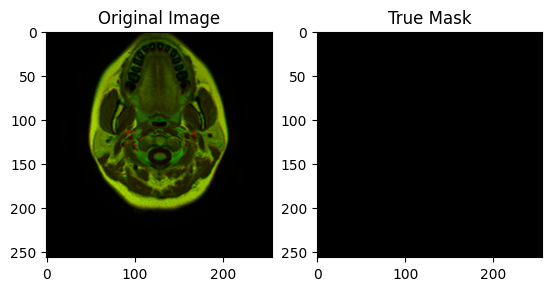

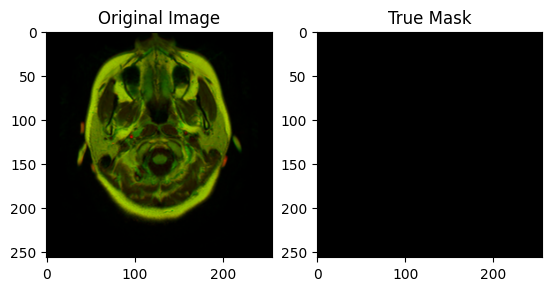

In [5]:
for i in range(3):
    print(image_files[i])
    print(mask_files[i])
    print()

image_files_tf = tf.data.Dataset.from_tensor_slices(image_files)
mask_files_tf = tf.data.Dataset.from_tensor_slices(mask_files)

ds = tf.data.Dataset.zip((image_files_tf, mask_files_tf))

ds = ds.map(lambda image_path, mask_path: tf.numpy_function(load_and_preprocess_image, [image_path, mask_path], [tf.float32, tf.float32]))

num_samples_to_inspect = 2
sample_dataset = ds.take(num_samples_to_inspect)

# Print the structure of the dataset
for image, mask in sample_dataset:
    plot(image, mask)

In [6]:
train_ds, val_ds, test_ds = dataset_partition(ds)
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [16]:
for image, true_mask in train_ds.take(15):
    #plot(image, true_mask)
    image_batched = np.expand_dims(image, axis=0)
    print(image.shape, true_mask.shape)
    pred_mask = model.predict(image_batched)
    pred_mask = np.squeeze(pred_mask, axis=0)
    if pred_mask.max() > 0.5:
        plot_predict(image, true_mask, pred_mask.astype(int))

(256, 256, 3) (256, 256, 3)
1/1 [==============================] - 0s 392ms/step
(256, 256, 3) (256, 256, 3)
1/1 [==============================] - 0s 415ms/step
(256, 256, 3) (256, 256, 3)
1/1 [==============================] - 0s 394ms/step
(256, 256, 3) (256, 256, 3)
1/1 [==============================] - 0s 389ms/step
(256, 256, 3) (256, 256, 3)
1/1 [==============================] - 0s 386ms/step
(256, 256, 3) (256, 256, 3)
1/1 [==============================] - 0s 394ms/step
(256, 256, 3) (256, 256, 3)
1/1 [==============================] - 0s 420ms/step
(256, 256, 3) (256, 256, 3)
1/1 [==============================] - 0s 397ms/step
(256, 256, 3) (256, 256, 3)
1/1 [==============================] - 0s 415ms/step
(256, 256, 3) (256, 256, 3)
1/1 [==============================] - 0s 394ms/step
(256, 256, 3) (256, 256, 3)
1/1 [==============================] - 0s 389ms/step
(256, 256, 3) (256, 256, 3)
1/1 [==============================] - 0s 402ms/step
(256, 256, 3) (256, 256, 3)


In [8]:
model.save('unet.keras')